# Análise de Absentismo - Call Center

**Objetivo:** Análise descritiva e prescritiva de padrões de absentismo.

**Dataset:** 1.3M registos, 3,135 colaboradores, 18 meses (2024-01 a 2025-06)

---

## GRUPO 3: SPELLS (EPISÓDIOS DE AUSÊNCIA)

**Spell** = Episódio contínuo de ausência (um ou mais dias consecutivos).

**Importância**:
- 1 spell de 5 dias vs 5 spells de 1 dia = **impacto operacional MUITO diferente**
- Permite calcular métricas sofisticadas:
  - **Frequency Rate**: Taxa de spells por colaborador
  - **Mean Spell Duration**: Duração média de cada episódio
  - **Short-term spells**: ≤ 3 dias (possível "abuso")
  - **Long-term spells**: > 14 dias (doença grave, tratamento médico)

**Algoritmo**:
1. Ordenar registos por colaborador e data
2. Identificar quebras de continuidade (gap > 1 dia)
3. Agrupar dias consecutivos no mesmo spell
4. Calcular duração, tipo predominante, etc.

### 3.1 Criar spells de AUSÊNCIA (usar df_faltas)

In [62]:
# Usar df_faltas criado no Grupo 2 (Falta Justificada + Falta Injustificada)
df_ausencias = df_faltas.copy()

print(f'   Registos de ausência (faltas): {len(df_ausencias):,}')
print(f'   Colaboradores com ausências: {df_ausencias["login_colaborador"].nunique():,}')

# Ordenar por colaborador e data
df_ausencias = df_ausencias.sort_values(['login_colaborador', 'Data']).reset_index(drop=True)

# Calcular diferença de dias entre registos consecutivos do mesmo colaborador
df_ausencias['dias_desde_anterior'] = df_ausencias.groupby('login_colaborador')['Data'].diff().dt.days

# Novo spell quando:
# 1. Primeiro registo do colaborador (dias_desde_anterior = NaN)
# 2. Gap > 1 dia (não consecutivo)
df_ausencias['novo_spell'] = (
    (df_ausencias['dias_desde_anterior'].isna()) |  # Primeiro registo
    (df_ausencias['dias_desde_anterior'] > 1)        # Gap de dias
)

# Atribuir ID único a cada spell
df_ausencias['spell_id'] = df_ausencias['novo_spell'].cumsum()

print(f'\n✓ Spells identificados: {df_ausencias["spell_id"].nunique():,}')
print(f'  (Um spell = episódio contínuo de ausência)')

   Registos de ausência (faltas): 24,511
   Colaboradores com ausências: 1,997

✓ Spells identificados: 7,600
  (Um spell = episódio contínuo de ausência)


### 3.2: Agregar Informação por Spell

In [64]:
df_spells = df_ausencias.groupby('spell_id').agg({
    'login_colaborador': 'first',
    'nome_colaborador': 'first',
    'categoria_profissional': 'first',
    'Data': ['min', 'max', 'count'],  # Início, fim, duração
    'Nivel 1': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],  # Tipo predominante
    'Nivel 2': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
}).reset_index()

# Renomear colunas
df_spells.columns = [
    'spell_id', 'login_colaborador', 'nome_colaborador', 'categoria_profissional',
    'data_inicio', 'data_fim', 'duracao_dias',
    'nivel1_predominante', 'nivel2_predominante'
]

# Adicionar operação se existir
if 'operacao' in df_ausencias.columns:
    df_spells = df_spells.merge(
        df_ausencias.groupby('spell_id')['operacao'].first().reset_index(),
        on='spell_id'
    )

# Adicionar features temporais
df_spells['dia_semana_inicio'] = df_spells['data_inicio'].dt.day_name()
df_spells['dia_semana_fim'] = df_spells['data_fim'].dt.day_name()
df_spells['mes'] = df_spells['data_inicio'].dt.month
df_spells['ano'] = df_spells['data_inicio'].dt.year

# Categorizar spells por duração
df_spells['categoria_spell'] = pd.cut(
    df_spells['duracao_dias'],
    bins=[0, 1, 3, 7, 14, float('inf')],
    labels=['1 dia', '2-3 dias', '4-7 dias', '8-14 dias', '>14 dias']
)

# Flags importantes
df_spells['short_term'] = df_spells['duracao_dias'] <= 3  # Ausências curtas (possível padrão)
df_spells['long_term'] = df_spells['duracao_dias'] > 14   # Ausências longas (doença grave)

print(f'\n✓ Dataset de spells criado: {len(df_spells):,} spells')
print(f'\nDistribuição por duração:')
print(df_spells['categoria_spell'].value_counts().sort_index())

print(f'\nEstatísticas de duração:')
print(f'   Média: {df_spells["duracao_dias"].mean():.2f} dias')
print(f'   Mediana: {df_spells["duracao_dias"].median():.0f} dias')
print(f'   P75: {df_spells["duracao_dias"].quantile(0.75):.0f} dias')
print(f'   P95: {df_spells["duracao_dias"].quantile(0.95):.0f} dias')
print(f'   Máximo: {df_spells["duracao_dias"].max()} dias')

# Insight importante para a direcção
pct_short_term = (df_spells['short_term'].sum() / len(df_spells)) * 100
pct_long_term = (df_spells['long_term'].sum() / len(df_spells)) * 100
print(f'\n📊 Insights:')
print(f'   {pct_short_term:.1f}% dos spells são curtos (≤3 dias) - possível padrão comportamental')
print(f'   {pct_long_term:.1f}% dos spells são longos (>14 dias) - casos de doença grave/recuperação')


✓ Dataset de spells criado: 7,600 spells

Distribuição por duração:
categoria_spell
1 dia        2953
2-3 dias     2706
4-7 dias     1661
8-14 dias     156
>14 dias      124
Name: count, dtype: int64

Estatísticas de duração:
   Média: 3.23 dias
   Mediana: 2 dias
   P75: 4 dias
   P95: 7 dias
   Máximo: 204 dias

📊 Insights:
   74.5% dos spells são curtos (≤3 dias) - possível padrão comportamental
   1.6% dos spells são longos (>14 dias) - casos de doença grave/recuperação


###  3.3: Análise de Spells por Colaborador

In [66]:
df_colab_spells = df_spells.groupby('login_colaborador').agg({
    'spell_id': 'count',  # Frequency rate (número de spells)
    'duracao_dias': ['sum', 'mean', 'median', 'std'],
    'short_term': 'sum',  # Número de spells curtos
    'long_term': 'sum',   # Número de spells longos
}).reset_index()

df_colab_spells.columns = [
    'login_colaborador', 'num_spells', 
    'total_dias_ausentes', 'mean_spell_duration', 'median_spell_duration', 'std_spell_duration',
    'num_short_term_spells', 'num_long_term_spells'
]

# Adicionar nome e categoria (que já estão em df_spells)
df_colab_spells = df_colab_spells.merge(
    df_spells[['login_colaborador', 'nome_colaborador', 'categoria_profissional']].drop_duplicates(),
    on='login_colaborador'
)

print(f'\n✓ Análise por colaborador criada: {len(df_colab_spells):,} colaboradores com ausências')

print(f'\n🔝 Top 10 colaboradores por número de spells (frequência de ausências):')
print('\nNome                                     | Spells | Dias Tot | Duração Média')
print('-' * 80)
for _, row in df_colab_spells.nlargest(10, 'num_spells').iterrows():
    print(f'{row["nome_colaborador"][:40]:40s} | {row["num_spells"]:6.0f} | {row["total_dias_ausentes"]:8.0f} | {row["mean_spell_duration"]:13.1f}')

print(f'\n🔝 Top 10 colaboradores por total de dias ausentes:')
print('\nNome                                     | Dias Tot | Spells | Duração Média')
print('-' * 80)
for _, row in df_colab_spells.nlargest(10, 'total_dias_ausentes').iterrows():
    print(f'{row["nome_colaborador"][:40]:40s} | {row["total_dias_ausentes"]:8.0f} | {row["num_spells"]:6.0f} | {row["mean_spell_duration"]:13.1f}')


✓ Análise por colaborador criada: 2,046 colaboradores com ausências

🔝 Top 10 colaboradores por número de spells (frequência de ausências):

Nome                                     | Spells | Dias Tot | Duração Média
--------------------------------------------------------------------------------
Teresa Zangui João Simão                 |     30 |      109 |           3.6
Ubirajara Sousa                          |     27 |       44 |           1.6
Antónia Bernardo Sonhi                   |     25 |       40 |           1.6
Arsénio Germano Aleixo António           |     25 |       49 |           2.0
Etieni Gomes Viegas                      |     23 |       54 |           2.3
Cláudia Nguimbi                          |     23 |       82 |           3.6
António Caramelo                         |     22 |       86 |           3.9
França Meno                              |     22 |       58 |           2.6
Adriana Fernandes Sumuini                |     21 |       38 |           1.8
Andréa 

### 3.4: Visualizações de Spells

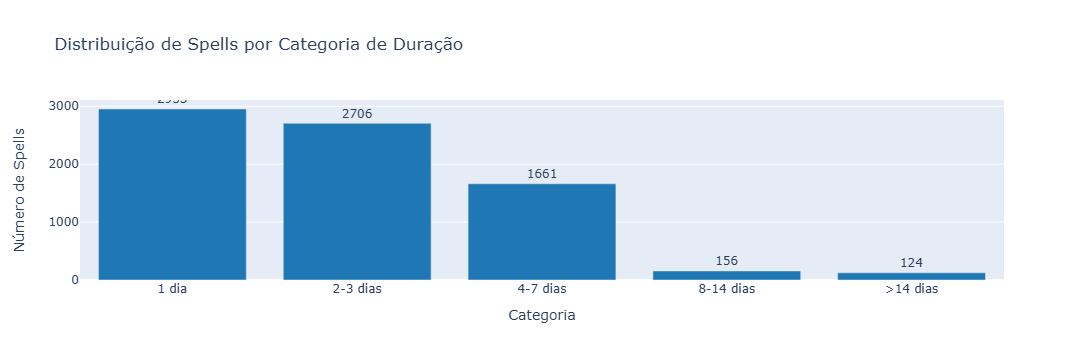

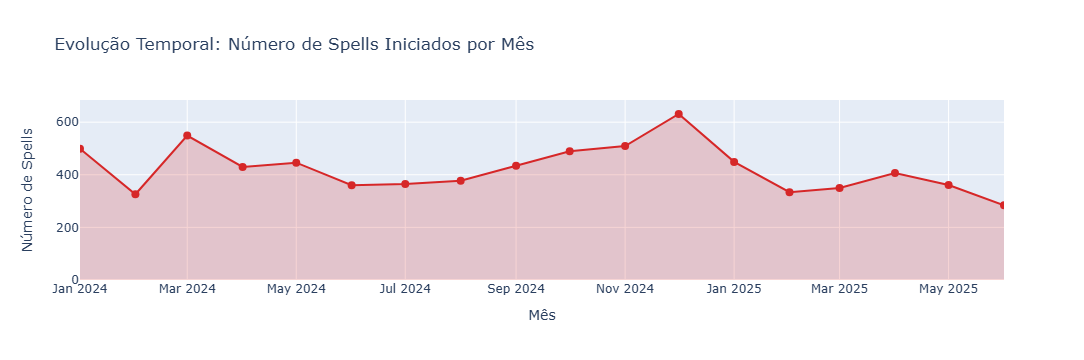

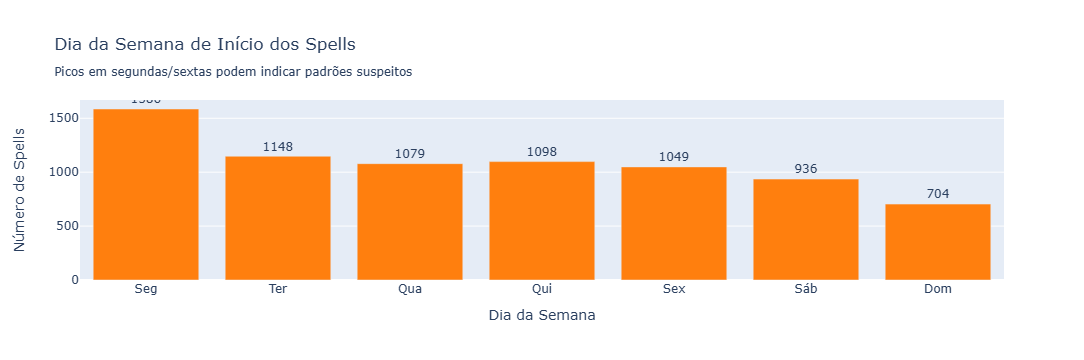

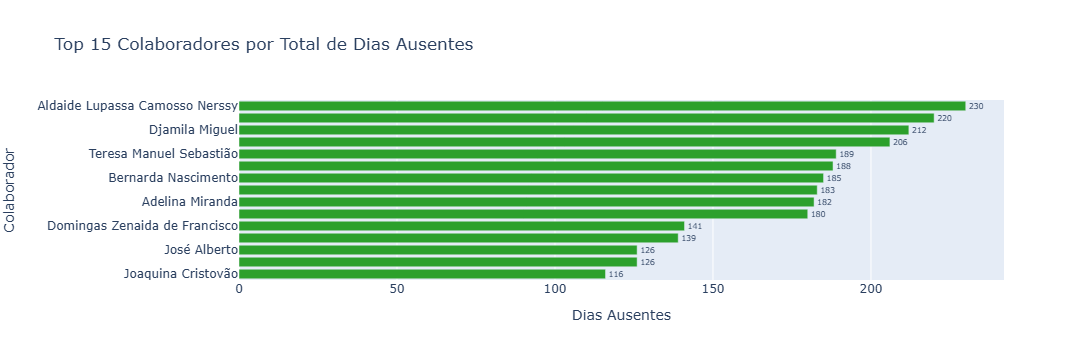

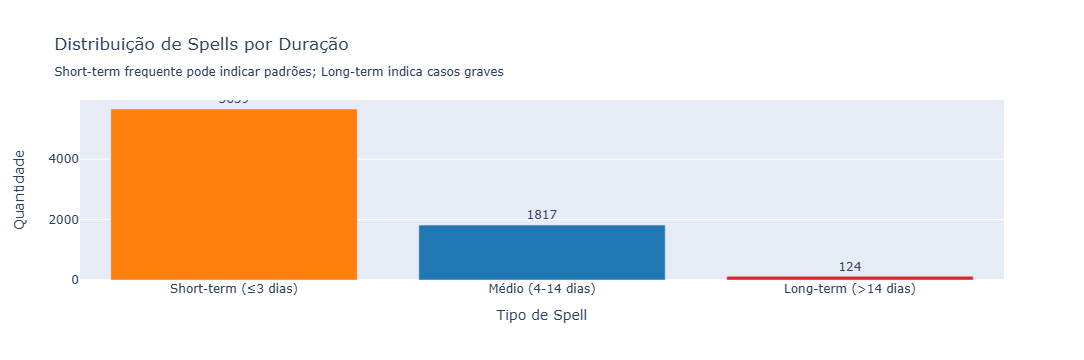


✓ Visualizações de spells criadas


In [68]:
# VIZ 1: Distribuição de duração de spells
cat_counts = df_spells['categoria_spell'].value_counts().sort_index()

fig1_alt = go.Figure()
fig1_alt.add_trace(go.Bar(
    x=cat_counts.index,
    y=cat_counts.values,
    marker_color='#1f77b4',
    text=cat_counts.values,
    textposition='outside'
))
fig1_alt.update_layout(
    title='Distribuição de Spells por Categoria de Duração',
    xaxis_title='Categoria',
    yaxis_title='Número de Spells',
    height=450
)
fig1_alt.show()

# VIZ 2: Evolução temporal de spells (número de spells iniciados por mês)
df_spells_temp = df_spells.copy()
df_spells_temp['ano_mes'] = df_spells_temp['data_inicio'].dt.to_period('M').astype(str)
spells_por_mes = df_spells_temp.groupby('ano_mes').size().reset_index(name='num_spells')

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=spells_por_mes['ano_mes'],
    y=spells_por_mes['num_spells'],
    mode='lines+markers',
    line=dict(color='#d62728', width=2),
    marker=dict(size=8),
    fill='tozeroy',
    fillcolor='rgba(214,39,40,0.2)'
))
fig2.update_layout(
    title='Evolução Temporal: Número de Spells Iniciados por Mês',
    xaxis_title='Mês',
    yaxis_title='Número de Spells',
    height=450,
    hovermode='x unified'
)
fig2.show()

# VIZ 3: Spells por dia da semana de início
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
spells_por_dia = df_spells['dia_semana_inicio'].value_counts().reindex(ordem_dias, fill_value=0)

fig3 = go.Figure()
fig3.add_trace(go.Bar(
    x=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
    y=spells_por_dia.values,
    marker_color='#ff7f0e',
    text=spells_por_dia.values,
    textposition='outside'
))
fig3.update_layout(
    title='Dia da Semana de Início dos Spells<br><sub>Picos em segundas/sextas podem indicar padrões suspeitos</sub>',
    xaxis_title='Dia da Semana',
    yaxis_title='Número de Spells',
    height=450
)
fig3.show()

# VIZ 4: Top 15 colaboradores por dias ausentes (barras horizontais)
top15_colab = df_colab_spells.nlargest(15, 'total_dias_ausentes').sort_values('total_dias_ausentes')

fig4 = go.Figure()
fig4.add_trace(go.Bar(
    y=[nome[:30] for nome in top15_colab['nome_colaborador']],
    x=top15_colab['total_dias_ausentes'],
    orientation='h',
    marker_color='#2ca02c',
    text=top15_colab['total_dias_ausentes'].astype(int),
    textposition='outside'
))
fig4.update_layout(
    title='Top 15 Colaboradores por Total de Dias Ausentes',
    xaxis_title='Dias Ausentes',
    yaxis_title='Colaborador',
    height=600,
    margin=dict(l=200)
)
fig4.show()

# VIZ 5: Comparação Short-term vs Long-term spells
spell_types = pd.DataFrame({
    'Tipo': ['Short-term\n(≤3 dias)', 'Médio\n(4-14 dias)', 'Long-term\n(>14 dias)'],
    'Quantidade': [
        df_spells['short_term'].sum(),
        ((df_spells['duracao_dias'] > 3) & (df_spells['duracao_dias'] <= 14)).sum(),
        df_spells['long_term'].sum()
    ]
})

fig5 = go.Figure()
fig5.add_trace(go.Bar(
    x=spell_types['Tipo'],
    y=spell_types['Quantidade'],
    marker_color=['#ff7f0e', '#1f77b4', '#d62728'],
    text=spell_types['Quantidade'],
    textposition='outside'
))
fig5.update_layout(
    title='Distribuição de Spells por Duração<br><sub>Short-term frequente pode indicar padrões; Long-term indica casos graves</sub>',
    xaxis_title='Tipo de Spell',
    yaxis_title='Quantidade',
    height=450
)
fig5.show()

print('\n✓ Visualizações de spells criadas')
print('='*70)


Analisando padrão de início de spells short-term por dia da semana...


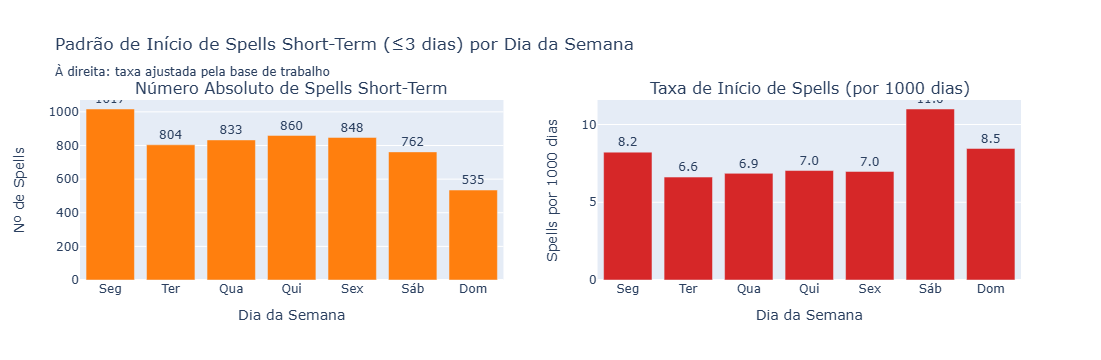


📊 Taxa de início de spells short-term (por 1000 dias de trabalho):

Dia       | Spells | Base      | Taxa (por 1000)
-------------------------------------------------------
Seg       |   1017 |   123,676 |            8.22
Ter       |    804 |   121,494 |            6.62
Qua       |    833 |   121,474 |            6.86
Qui       |    860 |   122,172 |            7.04
Sex       |    848 |   121,454 |            6.98
Sáb       |    762 |    69,295 |           11.00
Dom       |    535 |    63,235 |            8.46

⚠️  Dias com taxa acima da média (+10%): Sáb
   Possível padrão comportamental a investigar


In [69]:
# VIZ 3  Análise de spells short-term por dia da semana (com taxa ajustada)
print('\nAnalisando padrão de início de spells short-term por dia da semana...')

# Filtrar apenas spells short-term (≤3 dias)
df_spells_short = df_spells[df_spells['short_term'] == True].copy()

# Contar spells iniciados por dia da semana
ordem_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
spells_short_por_dia = df_spells_short['dia_semana_inicio'].value_counts().reindex(ordem_dias, fill_value=0)

# Calcular base (dias de trabalho) por dia da semana usando df_base_absentismo
base_por_dia = df_base_absentismo.groupby('Dia_Semana').size().reindex(ordem_dias, fill_value=0)

# Calcular taxa: spells iniciados por cada 1000 dias de trabalho
taxa_spells_por_dia = (spells_short_por_dia / base_por_dia * 1000).fillna(0)

# Criar gráfico comparativo
fig3 = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Número Absoluto de Spells Short-Term', 'Taxa de Início de Spells (por 1000 dias)'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}]]
)

# Subplot 1: Valores absolutos
fig3.add_trace(
    go.Bar(
        x=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
        y=spells_short_por_dia.values,
        marker_color='#ff7f0e',
        text=spells_short_por_dia.values,
        textposition='outside',
        name='Nº Spells'
    ),
    row=1, col=1
)

# Subplot 2: Taxa ajustada
fig3.add_trace(
    go.Bar(
        x=['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'],
        y=taxa_spells_por_dia.values,
        marker_color='#d62728',
        text=[f'{v:.1f}' for v in taxa_spells_por_dia.values],
        textposition='outside',
        name='Taxa'
    ),
    row=1, col=2
)

fig3.update_xaxes(title_text="Dia da Semana", row=1, col=1)
fig3.update_xaxes(title_text="Dia da Semana", row=1, col=2)
fig3.update_yaxes(title_text="Nº de Spells", row=1, col=1)
fig3.update_yaxes(title_text="Spells por 1000 dias", row=1, col=2)

fig3.update_layout(
    title_text='Padrão de Início de Spells Short-Term (≤3 dias) por Dia da Semana<br><sub>À direita: taxa ajustada pela base de trabalho</sub>',
    height=500,
    showlegend=False
)

fig3.show()

# Mostrar insights
print('\n📊 Taxa de início de spells short-term (por 1000 dias de trabalho):')
print('\nDia       | Spells | Base      | Taxa (por 1000)')
print('-' * 55)
dias_pt = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
for i, dia in enumerate(ordem_dias):
    print(f'{dias_pt[i]:9s} | {spells_short_por_dia[dia]:6.0f} | {base_por_dia[dia]:9,} | {taxa_spells_por_dia[dia]:15.2f}')

# Identificar dias com taxa anormalmente alta
taxa_media = taxa_spells_por_dia.mean()
dias_suspeitos = [dias_pt[i] for i, taxa in enumerate(taxa_spells_por_dia.values) if taxa > taxa_media * 1.1]

if dias_suspeitos:
    print(f'\n⚠️  Dias com taxa acima da média (+10%): {", ".join(dias_suspeitos)}')
    print('   Possível padrão comportamental a investigar')

In [70]:
df_spells.columns

Index(['spell_id', 'login_colaborador', 'nome_colaborador',
       'categoria_profissional', 'data_inicio', 'data_fim', 'duracao_dias',
       'nivel1_predominante', 'nivel2_predominante', 'operacao',
       'dia_semana_inicio', 'dia_semana_fim', 'mes', 'ano', 'categoria_spell',
       'short_term', 'long_term'],
      dtype='object')

In [71]:
def analisar_spells_por_periodo(df, titulo_suffix=""):
    # Adicionar dia do mês
    df['dia_mes'] = df['data_inicio'].dt.day

    # Categorizar em períodos de 3 dias
    def categorizar_periodo_mes(dia):
        if dia <= 3: return '01. Dias 1-3'
        elif dia <= 6: return '02. Dias 4-6'
        elif dia <= 9: return '03. Dias 7-9'
        elif dia <= 12: return '04. Dias 10-12'
        elif dia <= 15: return '05. Dias 13-15'
        elif dia <= 18: return '06. Dias 16-18'
        elif dia <= 21: return '07. Dias 19-21'
        elif dia <= 24: return '08. Dias 22-24'
        elif dia <= 27: return '09. Dias 25-27'
        else: return '10. Dias 28-31'

    df['periodo_mes'] = df['dia_mes'].apply(categorizar_periodo_mes)

    # Contagem
    spells_por_periodo = df['periodo_mes'].value_counts().sort_index()

    # Base de absentismo
    df_base_temp = df_base_absentismo.copy()
    df_base_temp['dia_mes'] = df_base_temp['Data'].dt.day
    df_base_temp['periodo_mes'] = df_base_temp['dia_mes'].apply(categorizar_periodo_mes)

    base_por_periodo = df_base_temp.groupby('periodo_mes').size()

    # Taxa
    taxa_spells_periodo = (spells_por_periodo / base_por_periodo * 1000).fillna(0)

    # ---- GRÁFICOS (igual ao teu) ----
    fig_mes = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f'Número Absoluto {titulo_suffix}',
                        f'Taxa de Início {titulo_suffix} (por 1000 dias)'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}]]
    )

    colors = ['#d62728' if i in [0, 9] else '#1f77b4' for i in range(10)]

    fig_mes.add_trace(
        go.Bar(
            x=spells_por_periodo.index,
            y=spells_por_periodo.values,
            text=spells_por_periodo.values,
            textposition='outside'
        ),
        row=1, col=1
    )

    fig_mes.add_trace(
        go.Bar(
            x=taxa_spells_periodo.index,
            y=taxa_spells_periodo.values,
            marker_color=colors,
            text=[f'{v:.1f}' for v in taxa_spells_periodo.values],
            textposition='outside'
        ),
        row=1, col=2
    )

    fig_mes.update_layout(height=500, showlegend=False)
    fig_mes.show()

    # ---- Insights ----
    taxa_inicio = taxa_spells_periodo['01. Dias 1-3']
    taxa_fim = taxa_spells_periodo['10. Dias 28-31']
    periodos_meio = [p for p in taxa_spells_periodo.index
                     if p not in ['01. Dias 1-3', '10. Dias 28-31']]
    taxa_meio = taxa_spells_periodo[periodos_meio].mean()

    print('\n📈 Comparação:')
    print(f'   Início: {taxa_inicio:.2f}')
    print(f'   Meio:   {taxa_meio:.2f}')
    print(f'   Fim:    {taxa_fim:.2f}')


##### Só short term

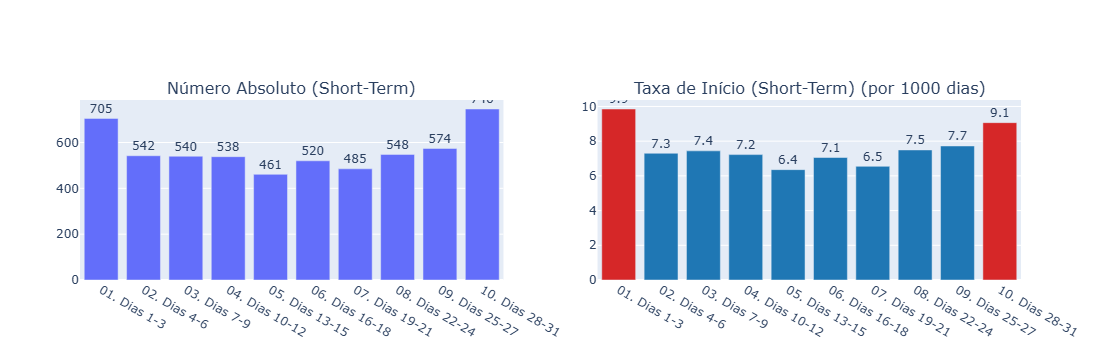


📈 Comparação:
   Início: 9.85
   Meio:   7.14
   Fim:    9.07


In [73]:
df_short = df_spells[df_spells['short_term'] == True].copy()
analisar_spells_por_periodo(df_short, "(Short-Term)")


##### Só Assistentes e short term

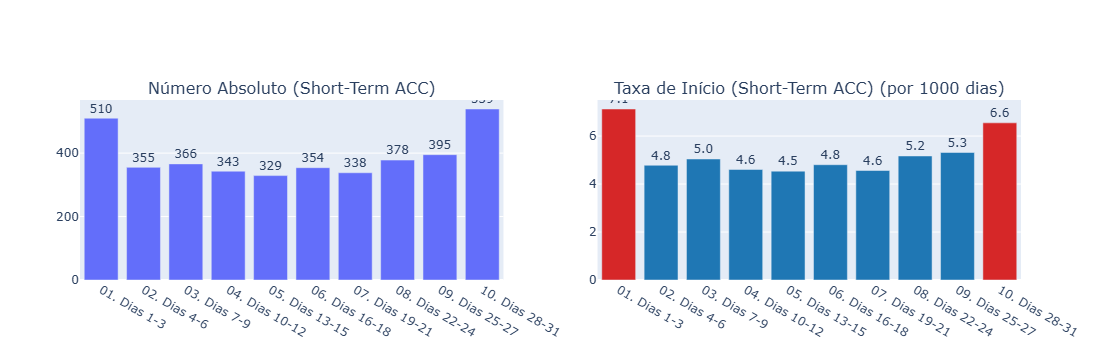


📈 Comparação:
   Início: 7.13
   Meio:   4.85
   Fim:    6.55


In [75]:
df_short_acc = df_spells[
    (df_spells['short_term'] == True) &
    (df_spells['categoria_profissional'] == "Assistente de Contact Center")
].copy()

analisar_spells_por_periodo(df_short_acc, "(Short-Term ACC)")


In [76]:
df_atrasos.shape

(761244, 17)

In [77]:
# ============================================================
# 4. MÉTRICAS CORE (KPIs Essenciais)
# ============================================================

print('\n=== MÉTRICAS CORE (Visão Global) ===')

# Período de análise
data_inicio = df_base_absentismo['Data'].min()
data_fim = df_base_absentismo['Data'].max()
dias_calendario = (data_fim - data_inicio).days + 1

print(f'Período analisado: {data_inicio.date()} até {data_fim.date()} ({dias_calendario} dias)')

# Total de colaboradores únicos
colabs = df_base_absentismo['login_colaborador'].nunique()
print(f'Colaboradores analisados: {colabs:,}')

# Total de faltas
total_faltas = len(df_faltas)

# Total de trabalho pago (presença)
total_trabalho_pago = len(df_absentismo[df_absentismo['Nivel 1'] == 'Trabalho Pago'])

# Base total
total_base = total_trabalho_pago + total_faltas

taxa_absentismo_global = (total_faltas / total_base * 100) if total_base > 0 else 0

print(f'\nTaxa de Absentismo Global: {taxa_absentismo_global:.2f}%')
print(f'Registos Trabalho Pago: {total_trabalho_pago:,}')
print(f'Registos Faltas: {total_faltas:,}')

# ------------------------------------------------------------
# Atrasos
# ------------------------------------------------------------


# Expandir Nivel 1 se existir lista
if isinstance(df_atrasos['Nivel 1'].iloc[0], list):
    df_atrasos = df_atrasos.explode('Nivel 1')

df_atrasos = df_atrasos[df_atrasos['Nivel 1'] == 'Atraso'].copy()

print(f'\nTotal de registos de Atraso: {len(df_atrasos):,}')

if len(df_atrasos) > 0:
    colabs_atrasos = df_atrasos['login_colaborador'].nunique()
    print(f'Colaboradores com atrasos: {colabs_atrasos:,}')
    pct_atrasos = (colabs_atrasos / colabs * 100)
    print(f'% da base com atrasos: {pct_atrasos:.2f}%')
else:
    print('Nenhum atraso registrado.')

# ------------------------------------------------------------
# Recorrência (quantidade de spells por colaborador)
# ------------------------------------------------------------
spells_por_colab = df_spells.groupby('login_colaborador').size()
media_spells = spells_por_colab.mean()

print(f'\nMédia de spells por colaborador: {media_spells:.2f}')

freq_acima_3 = (spells_por_colab > 3).mean() * 100
print(f'% colaboradores com mais de 3 spells: {freq_acima_3:.2f}%')

print('\n=== FIM do Grupo 4 ===')



=== MÉTRICAS CORE (Visão Global) ===
Período analisado: 2024-01-01 até 2025-06-30 (547 dias)
Colaboradores analisados: 3,131

Taxa de Absentismo Global: 3.30%
Registos Trabalho Pago: 718,289
Registos Faltas: 24,511

Total de registos de Atraso: 38,154
Colaboradores com atrasos: 2,258
% da base com atrasos: 72.12%

Média de spells por colaborador: 3.81
% colaboradores com mais de 3 spells: 39.36%

=== FIM do Grupo 4 ===
